## 1st. Block of questions

## Made a structure checking and clean up a column names.

Lib upload

In [96]:
import pandas as pd
import re


## File path



In [97]:
# 1) Загрузка файла (файл должен быть загружен в Colab через Upload)
df = pd.read_csv('/content/high-school-directory.csv', low_memory=False)

## Number of Rows and Colummns



In [98]:
print(f'Size: {df.shape[0]} Rows * {df.shape[1]} Columns')

Size: 435 Rows * 69 Columns


## Fully Empty Rows

In [99]:
empty_rows = df.applymap(lambda x: None if (isinstance(x, str) and x.strip() == "") else x)
fully_empty_rows = empty_rows.isna().all(axis=1).sum()
print('Empty Rows:', fully_empty_rows)

Empty Rows: 0


/tmp/ipython-input-2685130689.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_rows = df.applymap(lambda x: None if (isinstance(x, str) and x.strip() == "") else x)


## Column names fixing


In [100]:
def clean_col_name(name: str) -> str:
    s = str(name).strip().lower()          # lowercase + trim
    s = re.sub(r'[^\w\s]', ' ', s)         # special characters -> space
    s = re.sub(r'\s+', '_', s)             # spaces -> one _
    s = re.sub(r'_{2,}', '_', s)           # # consecutive _ -> one _
    s = s.strip('_')                       # remove _ from edges
    return s

df.columns = [clean_col_name(c) for c in df.columns]

print('Cleaned column headers ex.:', df.columns[:10])



Cleaned column headers ex.: Index(['dbn', 'school_name', 'borough', 'building_code', 'phone_number',
       'fax_number', 'grade_span_min', 'grade_span_max', 'expgrade_span_min',
       'expgrade_span_max'],
      dtype='object')


## Cleaned dataset saving



In [101]:
df.to_csv('high-school-directory-clean.csv', index=False)
print('Saved As high-school-directory-clean.csv')


Saved As high-school-directory-clean.csv


## 2nd. Block of questions

## Lib upload

In [102]:
import pandas as pd
import re


## CSV Loading

I am going to put my file (e.g., "high-school-directory-clean.csv") in the Collab working folder(done ot above).

In [103]:
df = pd.read_csv('high-school-directory-clean.csv', low_memory=False)

## Make column names consistent (lowercase, underscores) again

It's just from perspective to be sure that everything smoth.


In [104]:
def clean_col(name: str) -> str:
    s = str(name).strip().lower()
    s = re.sub(r'[^\w\s]', ' ', s)   # special chars -> space
    s = re.sub(r'\s+', '_', s)       # spaces -> underscore
    return s.strip('_')

df.columns = [clean_col(c) for c in df.columns]


## Some of the minimal sanity checks / light cleaning

Here I want to convert grade span to numeric, non-convertible -> NaN


In [105]:
# Converting grade span to numeric, non-convertible -> NaN

for col in ['grade_span_min', 'grade_span_max', 'total_students']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [106]:
# Normalize borough text (trim spaces); keep canonical names as-is

if 'borough' in df.columns:
    df['borough'] = df['borough'].astype(str).str.strip()


## Count of schools per borough

By using nunique() on school_name to avoid overcounting duplicates.


In [107]:
schools_per_borough = (
    df.groupby("borough")["school_name"]
      .nunique()
      .sort_values(ascending=False)
)

print("Count of unique schools per borough:")
print(schools_per_borough)
print()

Count of unique schools per borough:
borough
Brooklyn         121
Bronx            118
Manhattan        106
Queens            80
Staten Island     10
Name: school_name, dtype: int64



## Average number of students per borough

Mean of total_students per borough (I'll skip if the column is missing)


In [108]:
if 'total_students' in df.columns:
    avg_students_per_borough = (
        df.groupby('borough')['total_students']
          .mean()
          .round(2)
          .sort_values(ascending=False)
    )
    print('Average number of students per borough:')
    print(avg_students_per_borough)
    print()
else:
    print("Column 'total_students' not found; skipping average by borough.\n")


Average number of students per borough:
borough
Staten Island    1847.50
Queens           1046.64
Brooklyn          699.13
Manhattan         589.83
Bronx             490.41
Name: total_students, dtype: float64



## How many total schools are in Brooklyn?

IMPORTANT:  to use a range filter: min <= 9 <= max

In [109]:
if {'grade_span_min', 'grade_span_max'}.issubset(df.columns):
    grade9_count = df.loc[
        (df['grade_span_min'] <= 9) & (df['grade_span_max'] >= 9),
              'school_name'
    ].nunique()
    print(f'How many offer Grade 9 entry? {grade9_count}')
else:
    print("Columns 'grade_span_min'/'grade_span_max' not found; cannot check Grade 9 entry.")

How many offer Grade 9 entry? 432


## Conclusion

What am I done (briefly)

  - Column cleanup: ensures consistent names so, the code won’t break on minor header differences.
	- Schools per borough: groupby('borough')['school_name'].nunique() (avoids duplicates).
	- Average students per borough: mean of total_students per borough.
	- Total schools in Brooklyn: uses nunique() (per your requirement).
	- Grade 9 entry: counts schools where grade_span_min <= 9 <= grade_span_max (range check, per your requirement).


## VISUALIZATION


## Lib upload


In [110]:
import pandas as pd
import matplotlib.pyplot as plt


## Load the cleaned dataset


In [111]:
df = pd.read_csv("high-school-directory-clean.csv", low_memory=False)


## Ensure numeric column for total_students

Why?

I should ensure it’s numeric so you can calculate averages, counts, and create charts without errors.

In [112]:
df["total_students"] = pd.to_numeric(df["total_students"], errors="coerce")

## Clean borough labels and drop missing/invalid rows

In [113]:
df["borough"] = df["borough"].astype(str).str.strip()
df = df.dropna(subset=["borough", "total_students"])
df = df[df["total_students"] > 0]


## Calculate average students per borough


In [114]:
avg_students = (
    df.groupby("borough")["total_students"]
      .mean()
      .round(2)
      .sort_values(ascending=False)
)

## Bar Chart Plot: Distribution of student counts per borough

  Why am think think this is a good type of visual:

  - Bar charts are easy to compare across categories.
	- I can quickly see which borough has the largest and smallest average school sizes.
	- No outlier distortion like in boxplots — focus is on the average values.

 We can see which boroughs have generally larger schools and which have more variability.
 In most NYC data like this, Staten Island often shows a higher median because there are fewer schools but each serves more students.


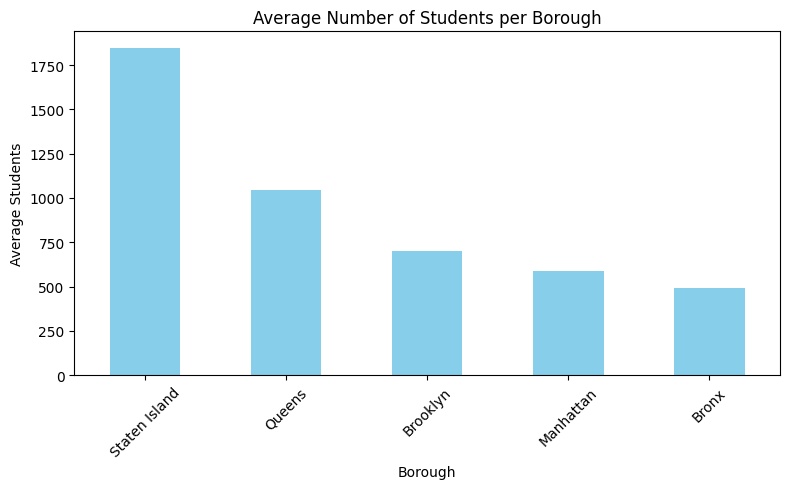

In [115]:
plt.figure(figsize=(8, 5))
avg_students.plot(kind="bar", color="skyblue")
plt.title("Average Number of Students per Borough")
plt.xlabel("Borough")
plt.ylabel("Average Students")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Histogram: Student counts across all boroughs

Shows the spread of school sizes within each borough.

	- Overlapping histograms let me quickly compare which boroughs have more small vs. large schools.
	- For example, Bronx might have more small-to-mid-size schools, while Queens or Staten Island may have peaks at higher student counts.

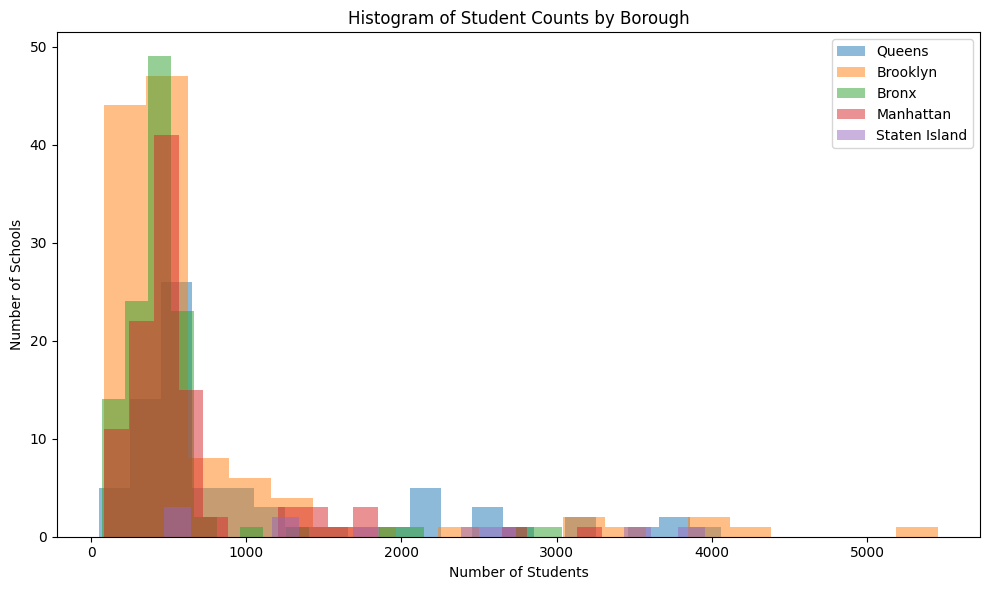

In [116]:
plt.figure(figsize=(10, 6))
for borough in df["borough"].unique():
    subset = df[df["borough"] == borough]["total_students"]
    plt.hist(subset, bins=20, alpha=0.5, label=borough)

plt.title("Histogram of Student Counts by Borough")
plt.xlabel("Number of Students")
plt.ylabel("Number of Schools")
plt.legend()
plt.tight_layout()
plt.show()
